# **Exoplanet Machine Learning Project**

**The goal of this project is to design and train a machine learning model that can predict whether a distant star has one or more exoplanets in its orbit. This project serves as both an exploration of deep learning techniques and a hands-on learning experience in working with time-series astronomical data.**

---


## **Dataset Preprocesing**  
The dataset is "Exoplanet Hunting in Deep Space" available through Kaggle (https://www.kaggle.com/datasets/keplersmachines/kepler-labelled-time-series-data).  The dataset includes data from multiple Kepler space telescope campaigns.  Each row represents a star monitored by Kepler and data points in columns are observed changes in light intensity of the star.  Such changes could be caused by an exoplanet orbiting the star and affecting the observable light as it passes.  Stars are labeled as either 1 (without exoplanets) or 2 (with exoplanet(s)).

---


### **Part 1: Getting Familiar with the Data**

In [1]:
import pandas as pd

# The dataset is already split into a portion for training and a portion for testing.
train_df = pd.read_csv("exoTrain.csv")
test_df = pd.read_csv("exoTest.csv")

In [2]:
# Get information about the nature of the dataset
train_df.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5087 entries, 0 to 5086
Columns: 3198 entries, LABEL to FLUX.3197
dtypes: float64(3197), int64(1)
memory usage: 124.1 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 570 entries, 0 to 569
Columns: 3198 entries, LABEL to FLUX.3197
dtypes: float64(3197), int64(1)
memory usage: 13.9 MB


In [3]:
train_df.head()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


In [4]:
# Shape = (num_rows, num_columns)
print(f"Train Shape: {train_df.shape}")
print(f"Test Shape: {test_df.shape}")

Train Shape: (5087, 3198)
Test Shape: (570, 3198)


In [5]:
# Check for missing data
train_df.isnull().sum()


LABEL        0
FLUX.1       0
FLUX.2       0
FLUX.3       0
FLUX.4       0
            ..
FLUX.3193    0
FLUX.3194    0
FLUX.3195    0
FLUX.3196    0
FLUX.3197    0
Length: 3198, dtype: int64

In [6]:
# Confirm that labels are either 1 (non-exoplanet star) or 2 (exoplanet star)
print("Unique Labels:", train_df.iloc[:, 0].unique())

Unique Labels: [2 1]


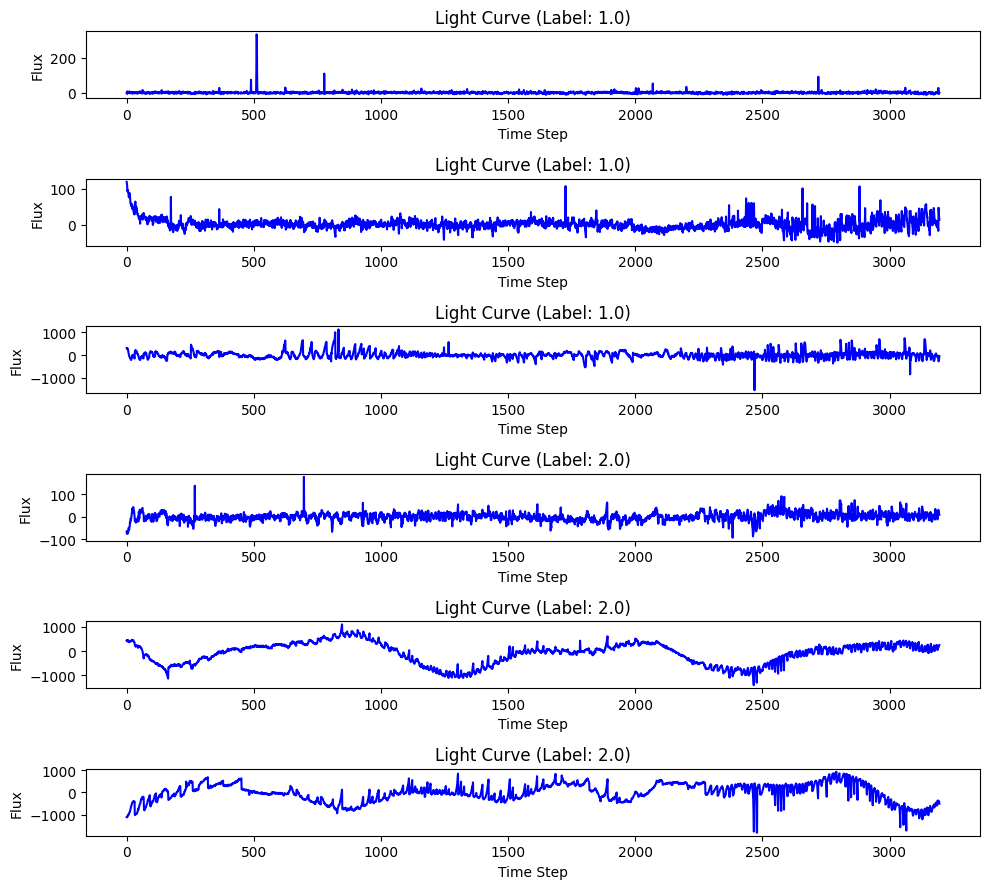

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Function to plot a few random light curves to understand the flux measurements.  Plots an equal number of exoplanet and non-exoplanet star light curves using a consistent flux scale.
def plot_random_light_curves(df, num_samples_per_class=3):
    
    plt.figure(figsize=(10, num_samples_per_class * 3))

    # Separate classes
    exoplanet_df = df[df.iloc[:, 0] == 2]
    non_exoplanet_df = df[df.iloc[:, 0] == 1]

    # Generate samples for each class
    exo_samples = exoplanet_df.sample(num_samples_per_class, random_state=42)
    non_exo_samples = non_exoplanet_df.sample(num_samples_per_class, random_state=42)

    # Combine samples for plotting
    samples = pd.concat([non_exo_samples, exo_samples])

    # Determine the flux range for all plots
    flux_min = df.iloc[:, 1:].min().min()
    flux_max = df.iloc[:, 1:].max().max()

    for i, (_, row) in enumerate(samples.iterrows()):
        flux_values = row[1:].values

        plt.subplot(num_samples_per_class * 2, 1, i + 1)
        plt.plot(flux_values, color="blue")
        plt.title(f"Light Curve (Label: {row.iloc[0]})")
        plt.xlabel("Time Step")
        plt.ylabel("Flux")

    plt.tight_layout()
    plt.show()

plot_random_light_curves(train_df, num_samples_per_class=3)

In [8]:
# Split dataset into X (features) and y (target)
X_train = train_df.drop(columns=["LABEL"])
y_train = train_df["LABEL"]

X_test = test_df.drop(columns=["LABEL"])
y_test = test_df["LABEL"]

# Check class distribution in the training set
unique, counts = np.unique(y_train, return_counts=True)
print("Training Set Class Distribution:", dict(zip(unique, counts)))

# Check class distribution in the test set
unique_test, counts_test = np.unique(y_test, return_counts=True)
print("Test Set Class Distribution:", dict(zip(unique_test, counts_test)))

Training Set Class Distribution: {np.int64(1): np.int64(5050), np.int64(2): np.int64(37)}
Test Set Class Distribution: {np.int64(1): np.int64(565), np.int64(2): np.int64(5)}


### **Analysis**  
 
The dataset is very skewed toward the label 1 class, with only a small fraction classed as label 2.  This will make it difficult for the model to predict label 2 with any confidence. Using a tool like Synthetic Minority Oversampling Technique (SMOTE) may help to avoid issues with this imbalance.  

---

### **Part 2: Finalize Data Prep**  
- Normalize flux values. Many deep learning models perform better with normalized features, especially when the data points vary widely.
- Apply SMOTE to balance class distribution
- Reshape data. The flux data shows changes over time, so a time-series model would be well-suited for this task.  Time-series models require data to be shaped in 3D.


In [9]:
from sklearn.preprocessing import StandardScaler

# Normalize flux values for better model performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [10]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance classes in the training dataset
sm = SMOTE(sampling_strategy="auto", random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train_scaled, y_train)

# Check new class distribution
unique_resampled, counts_resampled = np.unique(y_train_resampled, return_counts=True)
print("Balanced Training Data:", dict(zip(unique_resampled, counts_resampled)))

Balanced Training Data: {np.int64(1): np.int64(5050), np.int64(2): np.int64(5050)}


In [11]:
# Reshape from 2D to 3D (num_rows, num_cols, num_features). num_features = 1 because each time step has only 1 value (flux).
X_train_reshaped = np.reshape(X_train_resampled, (X_train_resampled.shape[0], X_train_resampled.shape[1], 1))
X_test_reshaped = np.reshape(X_test_scaled, (X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

# Confirm new shape
print("X_train shape:", X_train_reshaped.shape)
print("X_test shape:", X_test_reshaped.shape)
print("y_train shape:", y_train_resampled.shape)

X_train shape: (10100, 3197, 1)
X_test shape: (570, 3197, 1)
y_train shape: (10100,)


In [12]:
# Rename for easier use later
X_train = X_train_reshaped
X_test = X_test_reshaped
y_train = y_train_resampled

# Save data as numpy arrays
np.save("X_train.npy", X_train)
np.save("X_test.npy", X_test)
np.save("y_train.npy", y_train)
np.save("y_test.npy", y_test)